In [ ]:
# a reasonable alternative to BioconductR may be ggraph
# (for visualization and / or for analyses)

In [1]:
R.version.string

[1] "R version 3.6.1 (2019-07-05)"

In [ ]:
# Notes: 
# Sep 26, 2020: to get node labels, I had to add a field to the FIPEX BarrierHabitatLine table (the label is not automatically output)


### Graph creation and visualization using - ggraph and tidygraph

In [1]:
#as suggested by https://www.jessesadler.com/post/network-analysis-with-r/
library(tidyverse)
library(tidygraph)
library(ggraph)
library(tibble)
library(igraph)

# Jupyter R Notebooks can install packages (e.g.):
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")

#install.packages("rbenchmark", repos='http://cran.us.r-project.org')
#install.packages("data.table", repos='http://cran.us.r-project.org')
#install.packages("tidyverse", repos='http://cran.us.r-project.org')


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'tidygraph' was built under R version 3.6.3"
Attaching package: 'tidygraph'

The following object is masked from 'package:stats':

    filter

Warning message:
"package 'ggraph' was built under R version 3.6.3"
Attaching package: 'igraph'

The following object is masked from 'package:tidygraph':

    groups

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:purrr':

    compose, simplify

The following object is masked from 'package:tidyr':

    crossing

The following object is masked from 'package

In [18]:
#connectivity_data
# - table of barrier-to-barrier connectivity by barrier ID
connectivity_data<-read_csv("FIPEX_connectivity.csv")
connectivity_data

Parsed with column specification:
cols(
  ObID = col_double(),
  BarrierOrFlagID = col_double(),
  Downstream_Barrier = col_character(),
  BarrierOrFlagLabel = col_character(),
  Downstream_BarrierLabel = col_character()
)


ObID,BarrierOrFlagID,Downstream_Barrier,BarrierOrFlagLabel,Downstream_BarrierLabel
<dbl>,<dbl>,<chr>,<chr>,<chr>
1,3,Sink,H,Sink
2,6,Sink,I,Sink
3,9,3,G,H
4,13,3,F,H
5,17,3,K,H
6,19,3,D,H
7,18,9,M,G
8,12,13,J,F
9,30,17,N,K


In [19]:
barrier_info<-read_csv("FIPEX_BarrierHabitatLine.csv")
barrier_info

Parsed with column specification:
cols(
  ObID = col_double(),
  BarrierID = col_character(),
  Quantity = col_double(),
  BarrierPerm = col_double(),
  NaturalYN = col_logical(),
  BarrierOrFlagLabel = col_character()
)


ObID,BarrierID,Quantity,BarrierPerm,NaturalYN,BarrierOrFlagLabel
<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>
1,Sink,61.28,0.0,FALSE,Sink
2,3,89.48,0.5,FALSE,H
3,6,8.61,0.0,FALSE,I
4,9,18.08,0.5,FALSE,G
5,13,14.37,0.0,TRUE,F
6,17,27.89,0.2,TRUE,K
7,19,76.79,0.0,FALSE,D
8,18,9.61,0.0,FALSE,M
9,12,11.28,0.8,FALSE,J


In [28]:
#nodes
nodes <- barrier_info %>% 
# distinct just in case
distinct(BarrierID)%>%
rowid_to_column("id") %>%
rename(label = BarrierID) %>%
select(id, label)

nodes

id,label
<int>,<chr>
1,Sink
2,3
3,6
4,9
5,13
6,17
7,19
8,18
9,12


In [29]:
#edges
edges <- connectivity_data %>%
left_join(nodes, by = c("Downstream_Barrier" = "label")) %>%
rename(from = id) %>%
mutate(BarrierOrFlagID = as.character(BarrierOrFlagID)) %>%
left_join(nodes, by = c("BarrierOrFlagID" = "label")) %>%
rename(to = id) %>%
left_join(barrier_info, by = c("Downstream_Barrier" = "BarrierID")) %>%
rename(weight = Quantity) %>%
#mutate(weight = 1) %>% 
select(from,to,weight)

edges

from,to,weight
<int>,<int>,<dbl>
1,2,61.28
1,3,61.28
2,4,89.48
2,5,89.48
2,6,89.48
2,7,89.48
4,8,18.08
5,9,14.37
6,10,27.89


In [30]:
# this should report it is a 'rooted tree'
graph_tidy <- tbl_graph(nodes = nodes, edges = edges, directed = TRUE)
graph_tidy

# A tbl_graph: 15 nodes and 14 edges
#
# A rooted tree
#
# Node Data: 15 x 2 (active)
     id label
  <int> <chr>
1     1 Sink 
2     2 3    
3     3 6    
4     4 9    
5     5 13   
6     6 17   
# ... with 9 more rows
#
# Edge Data: 14 x 3
   from    to weight
  <int> <int>  <dbl>
1     1     2   61.3
2     1     3   61.3
3     2     4   89.5
# ... with 11 more rows

Using `tree` as default layout


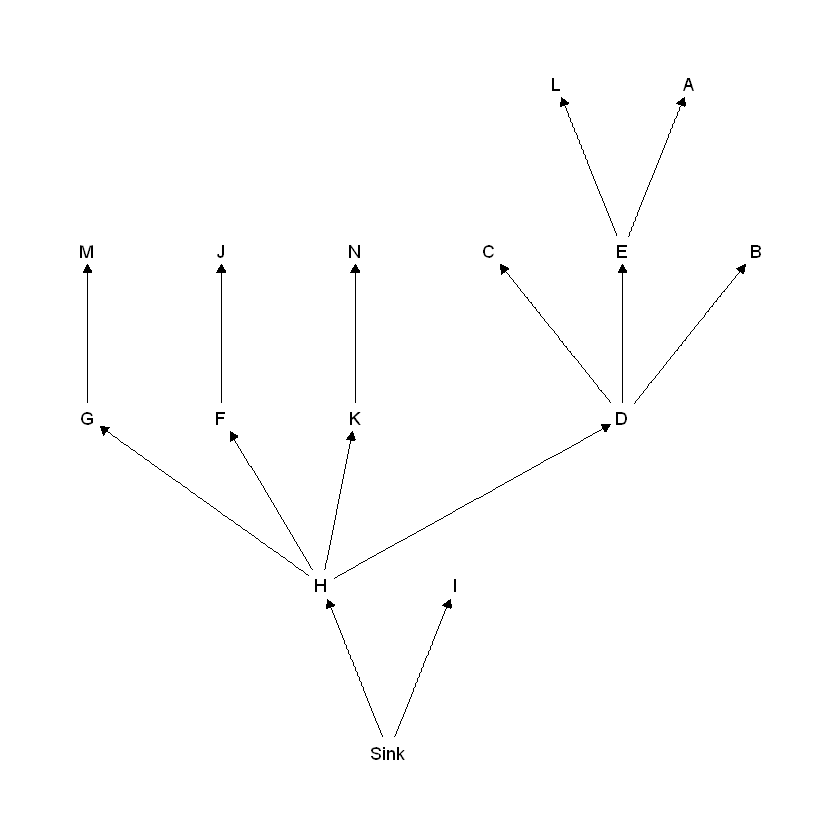

In [25]:
# ggraph inherits syntax of ggplot2
ggraph(graph_tidy) + 
#geom_node_point(fill = NA,
                #alpha = 0.5,
                #size = 2,
                #shape = 1,
                #stroke = 1,
                #fill = "red",
#                colour = "black") + 
geom_edge_link(aes(start_cap = label_rect(node1.label),
                       end_cap = label_rect(node2.label)),
               arrow = arrow(length = unit(0.2, "cm"),
                            type="closed")) + 
geom_node_text(aes(label = label), 
               repel = FALSE) +
scale_y_reverse() +
theme_graph()

# https://www.data-imaginist.com/2017/ggraph-introduction-nodes/
# https://www.data-imaginist.com/2017/ggraph-introduction-edges/
#https://ggplot2.tidyverse.org/reference/aes_colour_fill_alpha.html

## Using output from distance decay DCI table from FIPEX

In [51]:
fipex_advanced_dd<-read_csv("FIPEX_Advanced_DD_2020.csv")
fipex_advanced_dd

Parsed with column specification:
cols(
  NodeType = col_character(),
  NodeEID = col_double(),
  NodeLabel = col_character(),
  HabQuantity = col_double(),
  HabUnits = col_character(),
  BarrierPerm = col_double(),
  NaturalTF = col_logical(),
  DownstreamEID = col_character(),
  DownstreamNodeLabel = col_character(),
  DownstreamNeighDistance = col_double(),
  DistanceUnits = col_character()
)


NodeType,NodeEID,NodeLabel,HabQuantity,HabUnits,BarrierPerm,NaturalTF,DownstreamEID,DownstreamNodeLabel,DownstreamNeighDistance,DistanceUnits
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<chr>
Branch Junction,2,1,0.00,Square Metres,1.0,FALSE,Sink,Sink,44.47,Metres
Barrier,3,H,0.00,Square Metres,0.5,FALSE,2,1,3.63,Metres
Barrier,6,I,0.00,Square Metres,0.0,FALSE,2,1,13.17,Metres
Branch Junction,8,5,0.00,Square Metres,1.0,FALSE,3,H,18.47,Metres
Source Junction,4,2,44.36,Square Metres,1.0,FALSE,6,I,8.61,Metres
Barrier,9,G,0.00,Square Metres,0.5,FALSE,8,5,7.68,Metres
Branch Junction,11,7,0.00,Square Metres,1.0,FALSE,8,5,24.02,Metres
Barrier,18,M,141.92,Square Metres,0.0,FALSE,9,G,18.08,Metres
Barrier,13,F,0.00,Square Metres,0.0,TRUE,11,7,6.55,Metres


In [61]:
temp <- fipex_advanced_dd %>%
rowid_to_column("id")

maxid = max(temp$id)


[1] 35

In [62]:
#nodes
temp <- fipex_advanced_dd %>%
rowid_to_column("id")
maxid = max(temp$id)

# problems with igraph if node IDs are characters. Because 'sink' is in there, I generate new IDs.
nodes <- fipex_advanced_dd %>% 
# distinct just in case
#distinct(DownstreamEID)%>%
#rename(id = NodeEID) %>%
rename(label = NodeLabel) %>%
rowid_to_column("id") %>%
add_row(id = maxid + 1, label = "Sink") %>%
select(id, label)

nodes

id,label
<dbl>,<chr>
1,1
2,H
3,I
4,5
5,2
6,G
7,7
8,M
9,F


In [63]:
#edges
# do join since we are using newly generated ID's (as above)
edges <- fipex_advanced_dd %>%
# get the new ID for the downstream node
left_join(nodes, by = c("DownstreamNodeLabel" = "label")) %>%
rename(from = id) %>%
# get the id for the upstream node
mutate(NodeLabel = as.character(NodeLabel)) %>%
left_join(nodes, by = c("NodeLabel" = "label")) %>%
rename(to = id) %>%
rename(weight = HabQuantity) %>%
#mutate(weight = 1) %>% 
select(from,to,weight)

edges

from,to,weight
<dbl>,<dbl>,<dbl>
36,1,0.00
1,2,0.00
1,3,0.00
2,4,0.00
3,5,44.36
4,6,0.00
4,7,0.00
6,8,141.92
7,9,0.00


In [64]:
# this should report it is a 'rooted tree'
graph_tidy <- tbl_graph(nodes = nodes, edges = edges, directed = TRUE)
graph_tidy

# A tbl_graph: 36 nodes and 35 edges
#
# A rooted tree
#
# Node Data: 36 x 2 (active)
     id label
  <dbl> <chr>
1     1 1    
2     2 H    
3     3 I    
4     4 5    
5     5 2    
6     6 G    
# ... with 30 more rows
#
# Edge Data: 35 x 3
   from    to weight
  <int> <int>  <dbl>
1    36     1      0
2     1     2      0
3     1     3      0
# ... with 32 more rows

Using `tree` as default layout


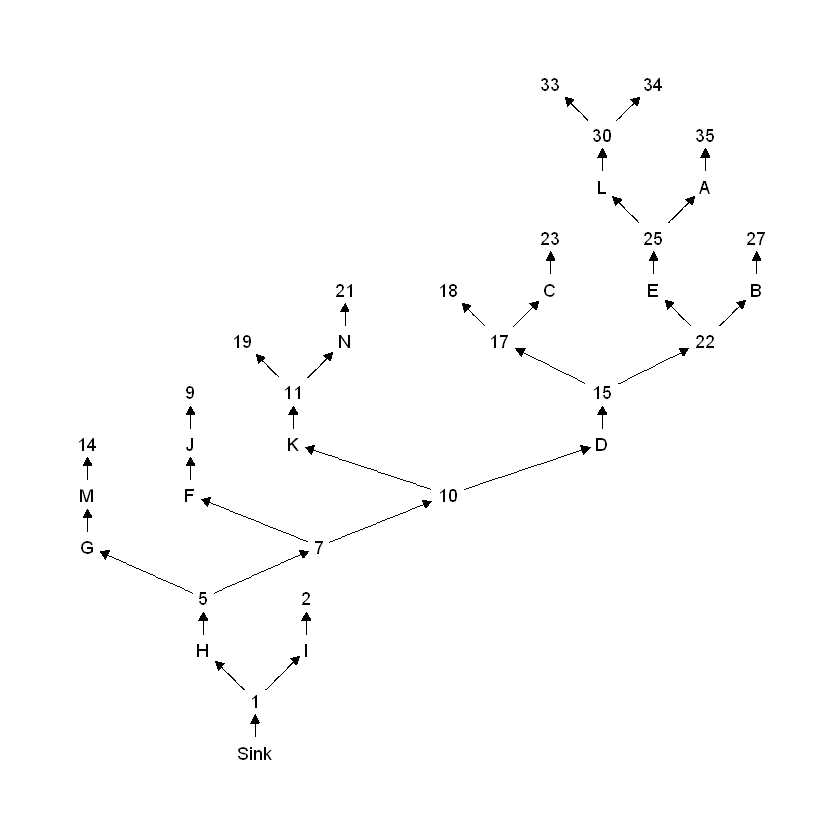

In [65]:
# ggraph inherits syntax of ggplot2
ggraph(graph_tidy) + 
#geom_node_point(fill = NA,
                #alpha = 0.5,
                #size = 2,
                #shape = 1,
                #stroke = 1,
                #fill = "red",
#                colour = "black") + 
geom_edge_link(aes(start_cap = label_rect(node1.label),
                       end_cap = label_rect(node2.label)),
               arrow = arrow(length = unit(0.2, "cm"),
                            type="closed")) + 
geom_node_text(aes(label = label), 
               repel = FALSE) +
scale_y_reverse() +
theme_graph()

### Experiments with Network Algorithms using igraph, ggraph etc

In [9]:
### Find Shortest paths
graph_tidy

# A tbl_graph: 12 nodes and 11 edges
#
# A rooted tree
#
# Node Data: 12 x 2 (active)
     id label
  <int> <chr>
1     1 Sink 
2     2 83   
3     3 84   
4     4 96   
5     5 98   
6     6 94   
# ... with 6 more rows
#
# Edge Data: 11 x 3
   from    to weight
  <int> <int>  <dbl>
1     1     2   569.
2     2     3  1778.
3     2     4  1778.
# ... with 8 more rows

In [10]:
allshortestpaths <- all_shortest_paths(graph_tidy,
                                       1,
                                       to = V(graph_tidy),
                                       mode = c("out", "all", "in"),
                                       weights = NULL)
# see https://igraph.org/r/doc/distances.html

t <- allshortestpaths$res[2]
typeof(t)
s<-t[[1]]
typeof(s)
u<-as.integer(s)
u[1]

[1] "list"

[1] "integer"

[1] 1

In [ ]:
# code below not working to generate an interactive version
# issues is probably just the Jupyter notebook format...
library(visNetwork)
library(networkD3)
library(htmlwidgets)
library(plotly)
#install.packages("visNetwork")
#install.packages("htmlwidgets")

In [ ]:
#not working in notebook
v<-visNetwork(nodes, edges)

In [ ]:
embed_notebook()